In [10]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])



# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [12]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


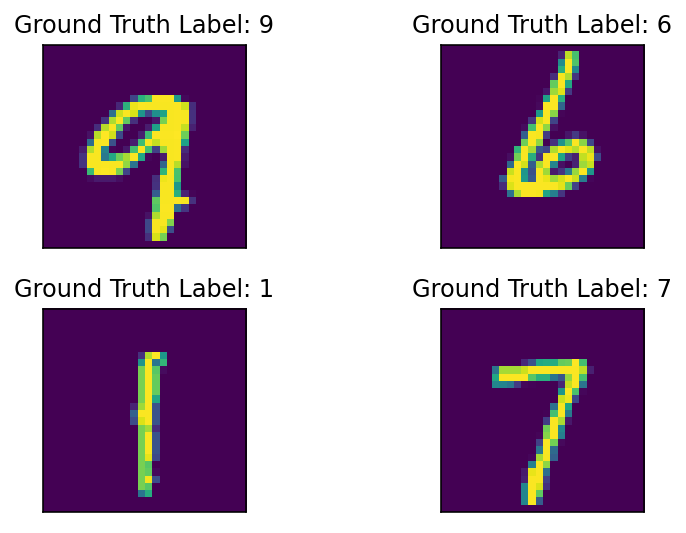

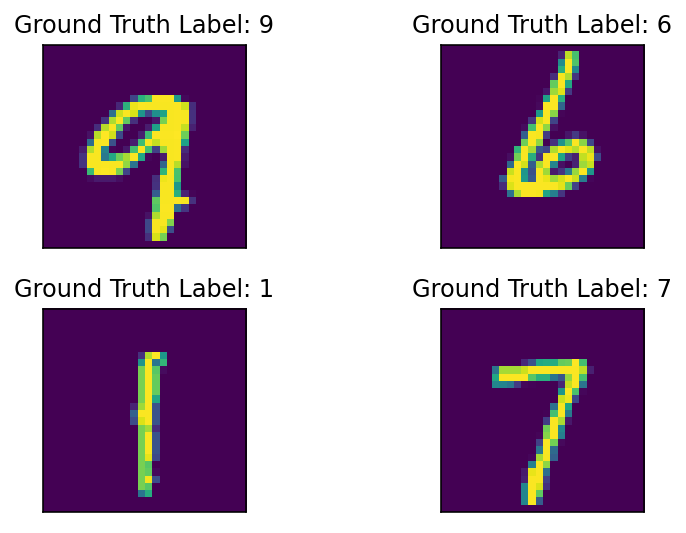

In [13]:
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0])
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
fig

In [14]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        # Convolutional Neural Network Layer 
        self.convolutaional_neural_network_layers = nn.Sequential(
                # Here we are defining our 2D convolutional layers
                # We can calculate the output size of each convolutional layer using the following formular
                # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
                # We have in_channels=1 because our input is a grayscale image
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                # After the first convolutional layer the output of this layer is:
                # [(28 + 2*1 - 3)/1] + 1 = 28. 
                nn.MaxPool2d(kernel_size=2), 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 28 / 2 = 14
          
                # output of our second conv layer
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # After the second convolutional layer the output of this layer is:
                # [(14 + 2*1 - 3)/1] + 1 = 14. 
                nn.MaxPool2d(kernel_size=2) 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 14 / 2 = 7
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                # We have the output_channel=24 of our second conv layer, and 7*7 is derived by the formular 
                # which is the output of each convolutional layer
                nn.Linear(in_features=24*7*7, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=64, out_features=10) # The output is 10 which should match the size of our class
        )

    # Defining the forward pass 
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = x.view(x.size(0), -1)
        # Then pass it through the linear layer
        x = self.linear_layers(x)
        # The softmax function returns the prob likelihood of getting the input image. 
        # We will see a much graphical demonstration below
        x = F.log_softmax(x, dim=1)
        return x

In [15]:
model = Network()
model.to(device)
print(model)

Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [16]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [17]:
epochs = 10 # The total number of iterations

train_losses = []
test_losses = []

for epoch in range(epochs):
    # prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader): 

        # Send these >>> To GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    else:
        # prep model for evaluation
        model.eval() 
        test_loss = 0
        accuracy = 0

        # Turn off the gradients when performing validation.
        # If we don't turn it off, we will comprise our networks weight entirely
        with torch.no_grad():
            for images, labels in testloader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                log_probabilities = model(images)
                test_loss += criterion(log_probabilities, labels)

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))
        
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
              "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)))

Epoch: 1/10   Training loss: 0.8945   Testing loss: 0.2910   Test accuracy: 0.9089  
Epoch: 2/10   Training loss: 0.2766   Testing loss: 0.1570   Test accuracy: 0.9527  
Epoch: 3/10   Training loss: 0.1867   Testing loss: 0.1087   Test accuracy: 0.9663  
Epoch: 4/10   Training loss: 0.1428   Testing loss: 0.0934   Test accuracy: 0.9716  
Epoch: 5/10   Training loss: 0.1176   Testing loss: 0.0726   Test accuracy: 0.9768  
Epoch: 6/10   Training loss: 0.1015   Testing loss: 0.0611   Test accuracy: 0.9798  
Epoch: 7/10   Training loss: 0.0917   Testing loss: 0.0579   Test accuracy: 0.9817  
Epoch: 8/10   Training loss: 0.0822   Testing loss: 0.0517   Test accuracy: 0.9833  
Epoch: 9/10   Training loss: 0.0769   Testing loss: 0.0500   Test accuracy: 0.9848  
Epoch: 10/10   Training loss: 0.0706   Testing loss: 0.0466   Test accuracy: 0.9851  


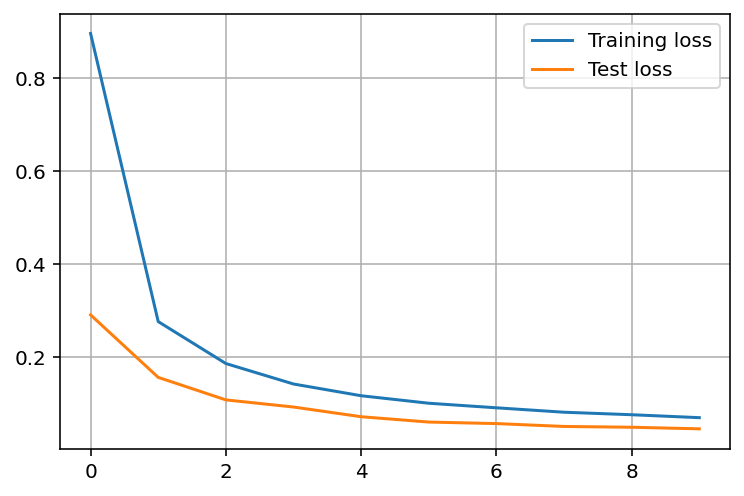

In [18]:

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.grid()

In [19]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


In [20]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[9.9999964e-01 1.9589477e-10 4.4642650e-08 1.0575528e-11 1.2591880e-10
 9.6833963e-10 3.3670239e-07 2.3720150e-09 1.6108065e-09 2.0179573e-10]


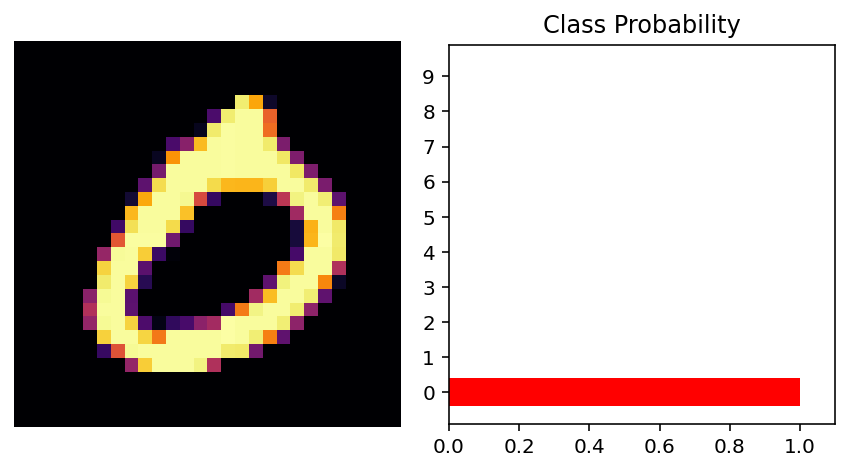

In [21]:
# We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

RNN

In [22]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [23]:
print(train_data)
print("\n")
print(test_data)
print("\n")
print(train_data.data.size())
print(train_data.targets.size())
print(train_data.data[0])

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


torch.Size([60000, 28, 28])
torch.Size([60000])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   

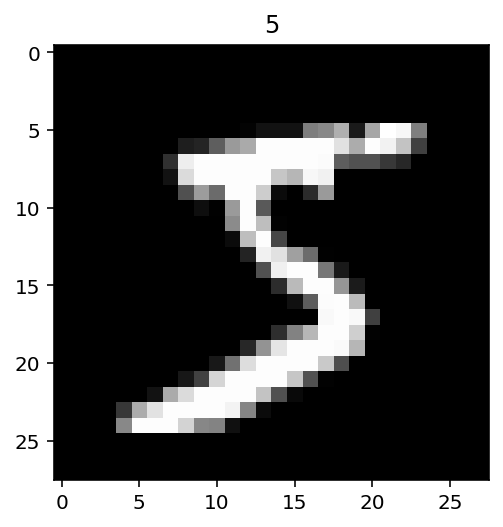

In [24]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

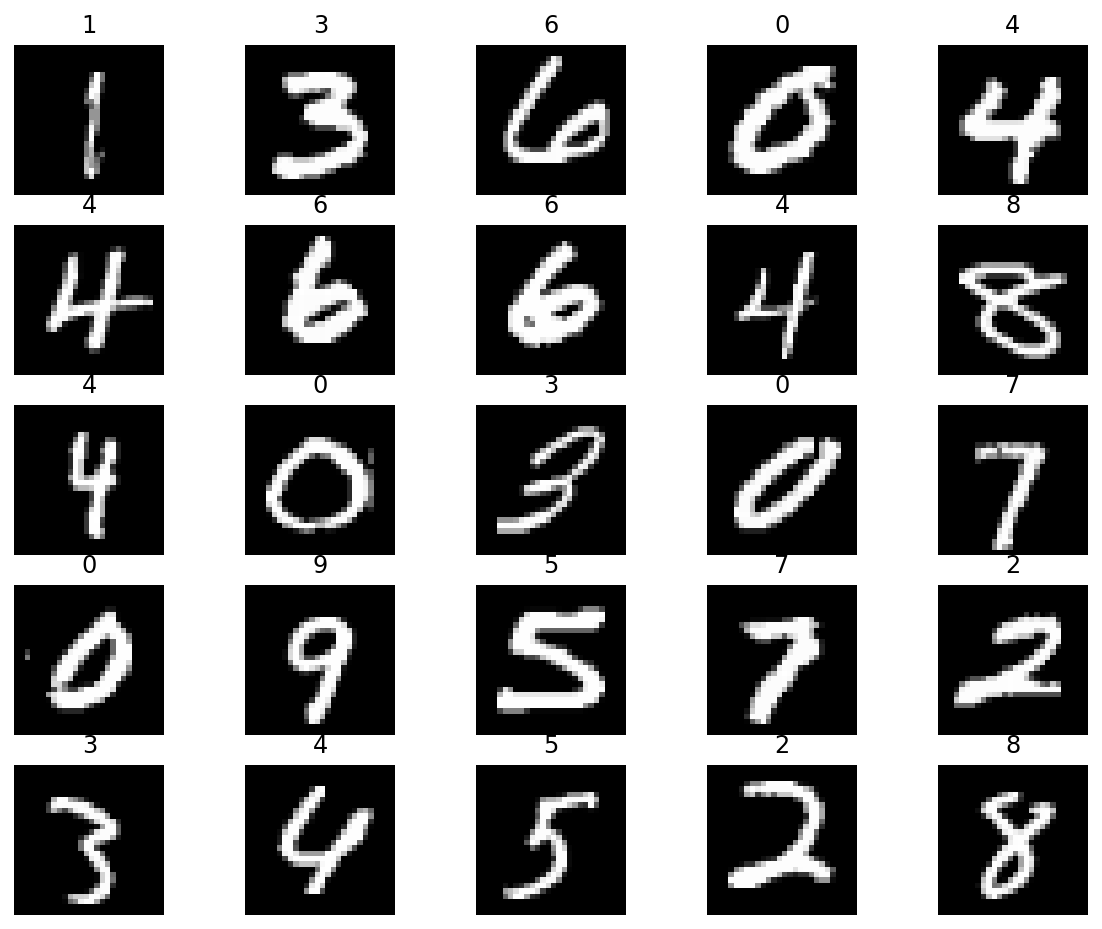

In [25]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [26]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x13d57f9b790>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x13d57dc28e0>}

In [27]:
from torch import nn
import torch.nn.functional as F

In [28]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [29]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        pass
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Passing in the input and hidden state into the model and  obtaining outputs
        out, hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out
       
        pass
pass
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
print(model)

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [30]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [31]:
def train(num_epochs, model, loaders):
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        
        pass
    pass
train(num_epochs, model, loaders)

Epoch [1/2], Step [100/600], Loss: 0.6761
Epoch [1/2], Step [200/600], Loss: 0.2691
Epoch [1/2], Step [300/600], Loss: 0.1808
Epoch [1/2], Step [400/600], Loss: 0.2199
Epoch [1/2], Step [500/600], Loss: 0.0381
Epoch [1/2], Step [600/600], Loss: 0.0782
Epoch [2/2], Step [100/600], Loss: 0.1395
Epoch [2/2], Step [200/600], Loss: 0.0594
Epoch [2/2], Step [300/600], Loss: 0.1445
Epoch [2/2], Step [400/600], Loss: 0.1034
Epoch [2/2], Step [500/600], Loss: 0.0501
Epoch [2/2], Step [600/600], Loss: 0.0963


In [32]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total = total + labels.size(0)
        correct = correct + (predicted == labels).sum().item()
print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 97.23 %


In [33]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [34]:
test_output = model(imgs[:10].view(-1, 28, 28))
predicted = torch.max(test_output, 1)[1].data.numpy().squeeze()
labels = lbls[:10].numpy()
print(f"Predicted number: {predicted}")
print(f"Actual number: {labels}")

Predicted number: [1 3 8 5 0 9 1 3 1 7]
Actual number: [1 3 8 5 0 9 1 3 1 7]


LSTM

In [35]:
train_dataset = datasets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = datasets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

In [36]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [37]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

In [38]:
criterion = nn.CrossEntropyLoss()

In [39]:
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [40]:
len(list(model.parameters()))

6

In [41]:
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

torch.Size([400, 28])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([10, 100])
torch.Size([10])


In [43]:
# Number of steps to unroll
seq_dim = 28  

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        # Load images as a torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        # outputs.size() --> 100, 10
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in testloader:
                # Resize images
                images = images.view(-1, seq_dim, input_dim)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.2863355875015259. Accuracy: 54.939998626708984
Iteration: 1000. Loss: 0.2691149115562439. Accuracy: 89.47000122070312
Iteration: 1500. Loss: 0.13059474527835846. Accuracy: 95.04000091552734


In [44]:
print(model)

LSTMModel(
  (lstm): LSTM(28, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)
